In [80]:
%load_ext autoreload
%autoreload 2
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import choice
from collections import defaultdict, Counter
from analysis_utils import get_data
from learning_utils import pickle_load, pickle_save, construct_pipeline, Participant, get_normalized_features,\
                            get_normalized_feature_values, construct_reward_function, reward_levels, reward_type, \
                            construct_repeated_pipeline, create_dir, get_strategy_counts, get_cluster_dict, \
                            get_modified_weights
from sequence_utils import compute_average_click_likelihoods
from generic_mouselab import GenericMouselabEnv
from modified_mouselab import TrialSequence, reward_val, normal_reward_val, constant_reward_val, decreasing_reward_val
from planning_strategies import strategy_dict
from rl_models import models as rl_models
from computational_microscope import ComputationalMicroscope
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from scipy.stats import ttest_ind, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy.linalg as LA
from scipy.special import softmax
from IPython.core.display import display, HTML
from experiment_utils import Experiment
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["axes.grid"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
def get_ds_weights(weights, features, feature_systems, decision_systems):
    ds_weights = defaultdict(int)
    for (f, w) in zip(features, weights):
        if feature_systems[f] == 'stopping_criteria' or f == "soft_pruning" or f == "termination_constant" or f=="is_previous_successor_negative":
            ds_weights[feature_systems[f]] += -w
        else:
            ds_weights[feature_systems[f]] += w
    return [ds_weights[ds] for ds in decision_systems]

def get_W_DS(W, features, feature_systems, decision_systems):
    num_strategies = W.shape[0]
    W_DS = []
    for i in range(num_strategies):
        W_DS.append(get_ds_weights(W[i], features, feature_systems, decision_systems))
    W_DS = np.array(W_DS)
    return W_DS

def get_ds_proportions(W_DS):
    DS_proportions = np.zeros_like(W_DS)
    for i in range(DS_proportions.shape[0]):
        total_w = np.sum([abs(w) for w in W_DS[i]])
        if total_w != 0:
            DS_proportions[i] = abs(W_DS[i])/total_w
    return DS_proportions

### Verifying which model wins the most for all distances

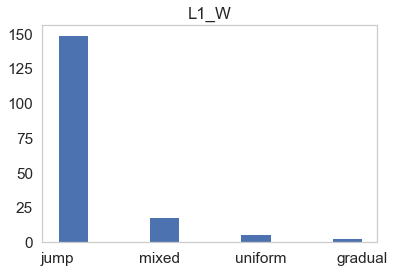

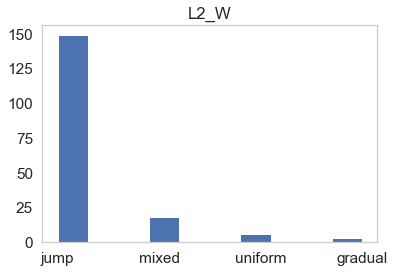

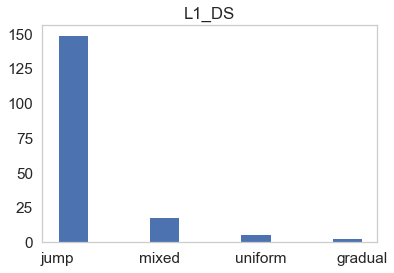

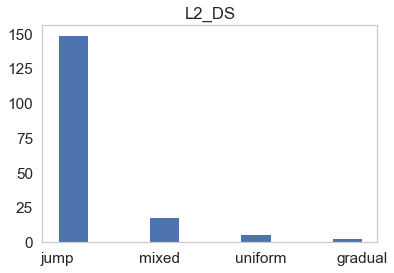

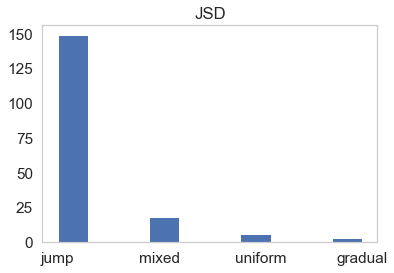

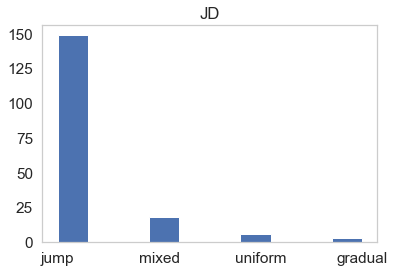

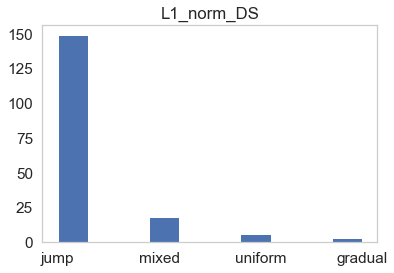

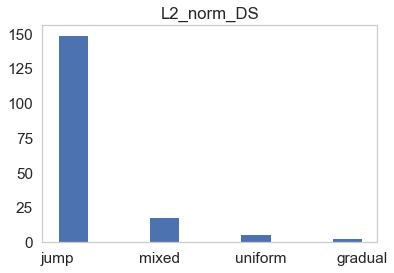

In [82]:
prior_transitions_v1 = pickle_load("data/prior_transitions_v1.pkl")
distances = ["L1_W", "L2_W", "L1_DS", "L2_DS", "JSD", "JD", "L1_norm_DS", "L2_norm_DS"]
distance_models = {}
for distance in distances:
    models = []
    for k in prior_transitions_v1[distance].keys():
        seq, T, transition_T, model = prior_transitions_v1[distance][k]
        models.append(model)
    distance_models[distance] = models
for distance in distances:
    plt.figure()
    plt.title(distance)
    plt.hist(models)

In [83]:
features = pickle_load("data/microscope_features.pkl")
decision_systems = pickle_load("data/decision_systems.pkl")

feature_systems = pickle_load("data/feature_systems.pkl")
decision_system_features = pickle_load("data/decision_system_features.pkl")
DS_proportions = pickle_load("data/strategy_decision_proportions.pkl")
W_DS = pickle_load("data/strategy_decision_weights.pkl")

strategy_weights = pickle_load("data/microscope_weights.pkl")

L1_DS = pickle_load("data/L1_DS.pkl")
L2_DS = pickle_load("data/L2_DS.pkl")
L1_norm_DS = pickle_load("data/L1_norm_DS.pkl")
L2_norm_DS = pickle_load("data/L2_norm_DS.pkl")

L1_distances = pickle_load("data/L1_distances.pkl")
L2_distances = pickle_load("data/L2_distances.pkl")
jeffreys_divergence = pickle_load("data/jeffreys_divergences.pkl")
jsd = pickle_load("data/js_divergences.pkl")

strategy_space = pickle_load("data/strategy_space.pkl")
num_strategies = len(strategy_space)
strategy_feature_scores = pickle_load("data/strategy_feature_scores.pkl") # Average scores using feature based representation of the strategies
strategy_scores = pickle_load("data/strategy_scores.pkl") # Average scores using an algorithmic representation of the strategies

clusters = pickle_load("data/kl_clusters.pkl")
cluster_map = pickle_load("data/kl_cluster_map.pkl")

cluster_scores = pickle_load("data/cluster_scores.pkl")

In [84]:
print(clusters)
cluster_dict = defaultdict(list)
for i, c in enumerate(clusters):
    cluster_dict[c].append(strategy_space[i])
for c in sorted(cluster_dict.keys()):
    print(cluster_dict[c])

[1, 13, 2, 5, 4, 5, 5, 1, 1, 2, 5, 5, 1, 13, 6, 10, 13, 13, 9, 8, 8, 13, 10, 10, 7, 10, 7, 5, 8, 8, 7, 4, 4, 13, 9, 9, 13, 9, 10, 5, 5, 5, 13, 13, 10, 12, 8, 4, 9, 9, 9, 9, 5, 5, 10, 13, 9, 8, 8, 7, 9, 8, 8, 13, 3, 10, 13, 11, 13, 10, 4, 8, 2, 5, 13, 13, 13, 13, 10]
[1, 8, 9, 13]
[3, 10, 82]
[72]
[5, 36, 37, 54, 79]
[4, 6, 7, 11, 12, 31, 45, 46, 47, 59, 60, 84]
[15]
[28, 30, 34, 66]
[22, 23, 32, 33, 53, 64, 65, 69, 70, 80]
[21, 40, 41, 43, 55, 56, 57, 58, 63, 67]
[16, 26, 27, 29, 44, 50, 61, 73, 78, 89]
[75]
[51]
[2, 14, 17, 18, 24, 39, 42, 48, 49, 62, 71, 74, 76, 85, 86, 87, 88]


In [85]:
print(cluster_scores)

{1: 32.858, 13: 32.37052941176471, 2: 33.15, 5: 33.656333333333336, 4: 32.0372, 6: 32.858, 10: 29.2685, 9: 36.2094, 8: 19.2238, 7: 7.529249999999999, 12: 38.322, 3: 32.858, 11: 35.683}


{1: 32.858, 2: 32.858, 3: 32.858, 4: 32.858, 5: 32.858, 6: 32.858, 7: 32.858, 8: 32.858, 9: 32.858, 10: 32.858, 11: 32.858, 12: 32.858, 13: 32.858, 14: 32.858, 15: 32.858, 16: 37.478, 17: 35.46, 18: 35.46, 19: 35.46, 20: 35.46, 21: 39.298, 22: 1.697, 23: 2.508, 24: 36.334, 25: 36.325, 26: 33.431, 27: 18.004, 28: 1.266, 29: 37.559, 30: 1.64, 31: 35.808, 32: 27.762, 33: 27.422, 34: 24.273, 35: 30.853, 36: 32.858, 37: 36.059, 38: 37.754, 39: 25.314, 40: 38.398, 41: 36.354, 42: 36.374, 43: 36.796, 44: 24.09, 45: 31.914, 46: 32.858, 47: 36.529, 48: 34.27, 49: 36.521, 50: 38.479, 51: 38.322, 52: 34.696, 53: 0.07, 54: 32.858, 55: 30.936, 56: 31.644, 57: 36.601, 58: 36.307, 59: 33.168, 60: 34.446, 61: 18.818, 62: 34.25, 63: 38.931, 64: 36.421, 65: 32.79, 66: 2.938, 67: 36.829, 68: 35.46, 69: 24.212, 70: 1.966, 71: 32.858, 72: 32.858, 73: 27.946, 74: 1.978, 75: 35.683, 76: 35.696, 77: 34.769, 78: 31.294, 79: 25.553, 80: 37.39, 81: 20.647, 82: 33.734, 83: 37.576, 84: 34.863, 85: 35.464, 86: 30.6

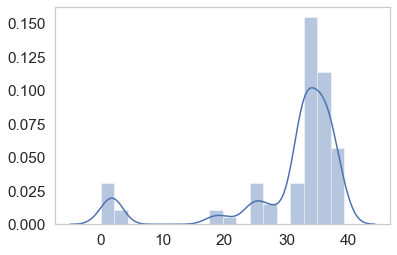

In [86]:
print(strategy_scores)
sns.distplot(list(strategy_scores.values()))

In [87]:
l = [s for s in range(1, 90) if s not in strategy_space]
print(l, len(l))

[19, 20, 25, 35, 38, 52, 68, 77, 81, 83] 10


In [88]:
W_DS = get_W_DS(strategy_weights, features, feature_systems, decision_systems)
DS_proportions = get_ds_proportions(W_DS)

### Partitioning the set of strategies into quartiles according a decision system

In [89]:
from scipy.stats.mstats import mquantiles
temp_DS_proportions = DS_proportions[[s-1 for s in strategy_space], :]
decision_proportion_df = pd.DataFrame(temp_DS_proportions, columns = decision_systems)
pd.options.display.max_rows = 1000
decision_quantiles = decision_proportion_df.quantile([0.33, 0.67], axis = 0)
max_proportions = decision_proportion_df.max()
strategies_by_level = {}
for ds in decision_systems:
    df = decision_proportion_df[ds].tolist()
    qs = mquantiles(df, prob=[0.33, 0.67])
    vals = [*qs, max_proportions[ds]]
    level_indices = [0]
    for i in range(0, len(vals) - 1):
        if vals[i] != vals[i+1]:
            level_indices.append(i+1)
    min_val = -1
    total_partitions = []
    for i in level_indices:
        partition = []
        max_val = vals[i]
        for s, val in enumerate(df):
            if val > min_val and val <= max_val:
                partition.append(strategy_space[s])
        total_partitions.append(partition)
        min_val = max_val
    strategies_by_level[ds] = total_partitions

In [90]:
print(strategies_by_level)

{'mental_effort_avoidance': [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 78, 80, 82, 85, 86, 87, 88, 89], [1, 18, 30, 45, 66, 76, 79, 84]], 'model_based': [[2, 5, 6, 7, 8, 9, 11, 12, 13, 15, 18, 23, 24, 30, 31, 33, 36, 37, 39, 42, 48, 49, 54, 61, 62, 63, 64, 67, 69, 71, 74, 75, 76, 78, 79, 80, 87], [16, 27, 28, 41, 44, 45, 47, 57, 60, 65, 66, 70, 84, 86, 88, 89], [1, 3, 4, 10, 14, 17, 21, 22, 26, 29, 32, 34, 40, 43, 46, 50, 51, 53, 55, 56, 58, 59, 72, 73, 82, 85]], 'pavlovian': [[2, 3, 4, 6, 7, 10, 12, 23, 24, 26, 27, 30, 31, 32, 33, 39, 40, 46, 47, 48, 49, 53, 54, 55, 56, 60, 61, 66, 71, 72, 73, 74, 78, 82, 85, 86, 87, 88], [1, 9, 13, 28, 34, 41, 43, 44, 45, 57, 59, 64, 65, 70, 84], [5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 29, 36, 37, 42, 50, 51, 58, 62, 63, 67, 69, 75, 76, 79, 80, 89]], '

### Validation of decision systems

In [91]:
print(decision_systems)

['mental_effort_avoidance', 'model_based', 'pavlovian', 'pruning', 'relational', 'satisficing', 'stopping_criteria', 'structural']


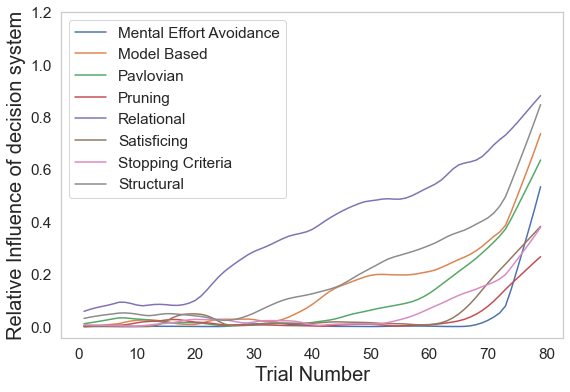

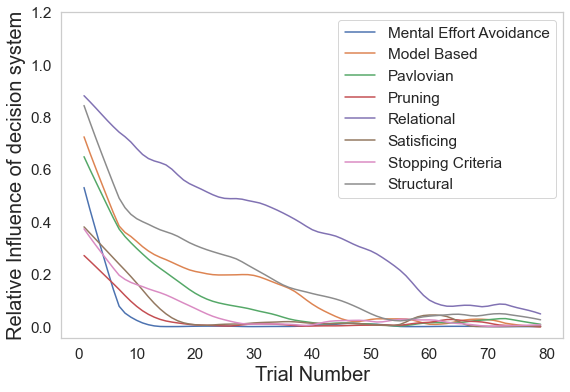

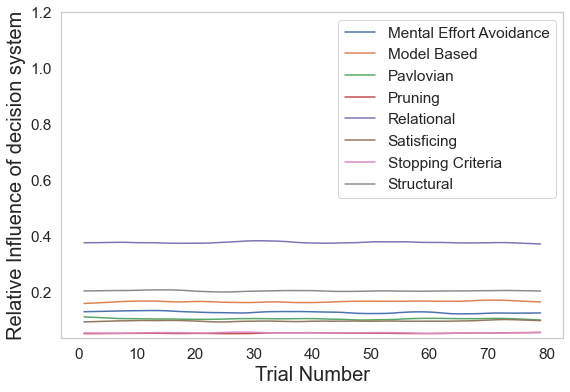

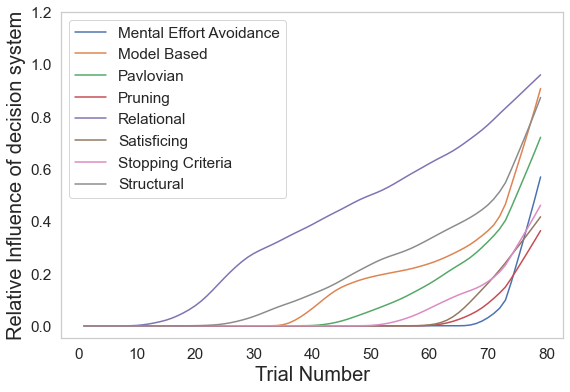

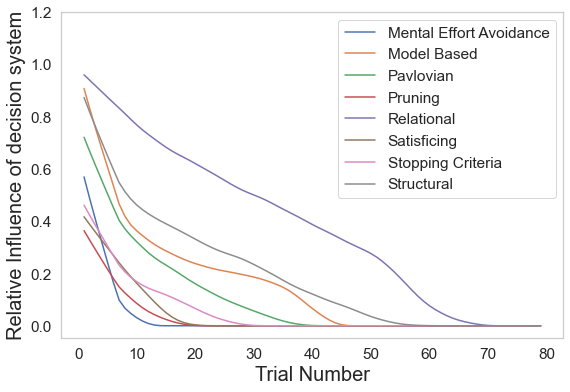

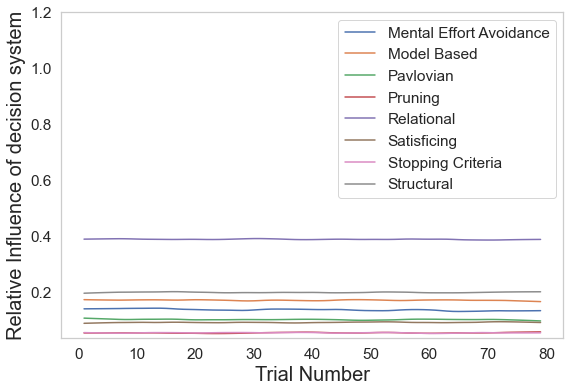

In [92]:
from learning_utils import smoothen
ds_validation_sequences = pickle_load("data/ds_validation_sequences.pkl")
trends = ["inc", "dec", "const"]
trend_labels = ["Increasing", "Decreasing", "Constant"]
num_seq = 500
num_decision_systems = len(decision_systems)
trend_inferred = defaultdict(lambda: defaultdict(list))
trend_actual = defaultdict(lambda: defaultdict(list))
for trend in trends:
    for decision_system_index in range(len(decision_systems)):
        for run_num in range(num_seq):
            inferred, actual = ds_validation_sequences[decision_system_index][trend][run_num]
            ds_validation_sequences[decision_system_index][trend].append((inferred, actual))
            inferred_props = [DS_proportions[s-1][decision_system_index] for s in inferred]
            actual_props = [DS_proportions[s-1][decision_system_index] for s in actual]
            trend_inferred[trend][decision_systems[decision_system_index]].append(inferred_props)
            trend_actual[trend][decision_systems[decision_system_index]].append(actual_props)
for trend in trends:
    for decision_system in decision_systems:
        trend_inferred[trend][decision_system] = np.mean(trend_inferred[trend][decision_system], axis = 0)
        trend_actual[trend][decision_system] = np.mean(trend_actual[trend][decision_system], axis = 0)
        
decision_system_labels = [" ".join([str(l.capitalize()) for l in d.split("_")]) for d in decision_systems]
create_dir("results/decision_system_validation_plots")
figure_size = (9, 6)
for trend_index, trend in enumerate(trends):
    plt.figure(figsize = figure_size)
    for index, decision_system in enumerate(decision_systems):
        y = smoothen(trend_inferred[trend][decision_system]) # Change this later if smoothening is not required
        #y = trend_inferred[trend][decision_system]
        plt.plot(range(1, len(y) + 1), y, label = decision_system_labels[index])
    #plt.title(trend_labels[trend_index])
    plt.xlabel("Trial Number", fontsize=20)
    plt.ylabel("Relative Influence of decision system", fontsize=20)
    plt.ylim(top = 1.2)
    plt.legend()
    plt.savefig(f"results/decision_system_validation_plots/{trend}_inferred.png", bbox_inches='tight')
for trend_index, trend in enumerate(trends):
    plt.figure(figsize = figure_size)
    for index, decision_system in enumerate(decision_systems):
        y = smoothen(trend_actual[trend][decision_system]) # Change this later if smoothening is not required
        #y = trend_actual[trend][decision_system]
        plt.plot(range(1, len(y) + 1), y, label = decision_system_labels[index])
    #plt.title(trend_labels[trend_index])
    plt.xlabel("Trial Number", fontsize=20)
    plt.ylabel("Relative Influence of decision system", fontsize=20)
    plt.ylim(top = 1.2)
    plt.legend()
    plt.savefig(f"results/decision_system_validation_plots/{trend}_actual.png", bbox_inches='tight')

### Cluster wise decision system representation

In [93]:
cluster_DS_props = defaultdict(list)
for i, cluster in enumerate(clusters):
    cluster_DS_props[cluster].append(DS_proportions[strategy_space[i]-1])
threshold = 0.75
for cluster in sorted(cluster_DS_props.keys()):
    print(cluster)
    m = np.mean(cluster_DS_props[cluster], axis=0)
    sorted_m_indices = np.argsort(m)[::-1]
    sorted_m = np.sort(m)[::-1]
    sum_sorted_m = np.cumsum(sorted_m)
    print(sorted_m)
    for i, sm in enumerate(sum_sorted_m):
        if sm > threshold:
            break
    print([decision_systems[j] for j in sorted_m_indices[:i+1]])

1
[0.36867299 0.23546092 0.21330057 0.09894494 0.05659538 0.0270252
 0.         0.        ]
['structural', 'pruning', 'relational']
2
[0.77940803 0.17796949 0.0234146  0.01920789 0.         0.
 0.         0.        ]
['model_based']
3
[0.73898369 0.26101631 0.         0.         0.         0.
 0.         0.        ]
['relational', 'model_based']
4
[5.18324675e-01 2.09858043e-01 1.80742555e-01 7.06560411e-02
 2.04157134e-02 2.97232813e-06 0.00000000e+00 0.00000000e+00]
['relational', 'pavlovian', 'structural']
5
[0.55828112 0.12927222 0.12257904 0.08739034 0.04226478 0.02923242
 0.02759012 0.00338995]
['relational', 'stopping_criteria', 'model_based']
6
[0.3836845  0.37283024 0.24348526 0.         0.         0.
 0.         0.        ]
['structural', 'pavlovian']
7
[0.49499457 0.26780618 0.16147323 0.03283021 0.02797369 0.01492211
 0.         0.        ]
['relational', 'mental_effort_avoidance']
8
[0.28135618 0.26167886 0.18050246 0.11693405 0.07706459 0.05425458
 0.02820928 0.        ]


### Validation

In [94]:
def get_standard_error(vals):
    std = np.std(vals)
    return np.round(std/np.sqrt(len(vals)), 3)

In [95]:
def get_confusion(s_true, s_pred):
    unique_true_s = np.unique(s_true + s_pred)
    unique_true_s.sort()
    num_unique = unique_true_s.shape[0]
    s_index = {s:i for i,s in enumerate(unique_true_s)}
    confusion_matrix = np.zeros((num_unique, num_unique))
    for t,p in zip(s_true, s_pred):
        confusion_matrix[s_index[t]][s_index[p]] += 1
    return confusion_matrix

def get_accuracy(confusion_matrix):
    counts = []
    total_count = np.sum(confusion_matrix)
    for k in range(confusion_matrix.shape[0]):
        counts.append(confusion_matrix[k][k])
    return np.round(np.sum(counts)/total_count, 3)
        
def get_confusions(s_true, s_pred, cluster_map):
    strategy_confusion = get_confusion(s_true, s_pred)
    c_true = [cluster_map[s+1] for s in s_true]
    c_pred = [cluster_map[s+1] for s in s_pred]
    cluster_confusion = get_confusion(c_true, c_pred)
    return strategy_confusion, cluster_confusion

In [96]:
def get_proportion_confusion(confusion_matrix, strategy_space): # We need inferred wrt true
    num_categories = confusion_matrix.shape[0]
    proportion_confusion = {}
    for i in range(num_categories):
        num_counts = confusion_matrix[:, i]
        num_counts = num_counts/num_counts.sum()
        proportion_confusion[strategy_space[i]] = {strategy_space[j]:np.round(c,3) for j,c in enumerate(num_counts)}
    return proportion_confusion

#### Mechanisms

In [97]:
def compute_average_confusion_index(strategy_confusion):
    indexes = []
    modified_jd = jeffreys_divergence[[s-1 for s in strategy_space], :]
    for i in range(strategy_confusion.shape[0]):
        for j in range(strategy_confusion.shape[1]):
            C = strategy_confusion[i][j] 
            if i!=j and C!=0:
                x = np.sort(modified_jd[i]).tolist()
                #print(x)
                index = x.index(modified_jd[i][j])
                #print(modified_jd[i][j], index, C)
                indexes += [index]*int(C)
    #plt.hist(indexes)
    print(np.mean(indexes), np.median(indexes))

In [98]:
def get_proportion_se(p, n):
    return np.sqrt(p*(1-p)/n)

In [99]:
strategy_validation_sequences = pickle_load("data/strategy_validation_sequences.pkl")
models = ["random", "random_switch", "gradual", "mixed", "bernoulli_rssl"]
distance = "L2_W"
num_seq = 500
TRUE_S = []
INFERRED_S = []
for model in models:
    total_accs = []
    true_s = []
    inferred_s = []
    for i in range(num_seq):
        acc, data = strategy_validation_sequences[model][distance][i]
        strategy_validation_sequences[model][distance].append((acc, data))
        true = data[0]['s']
        inferred = data[0]['inferred']
        total_accs.append(acc)
        true_s += true
        inferred_s += inferred
        TRUE_S += true
        INFERRED_S += inferred
    num_trials = len(inferred_s)
    strategy_confusion, cluster_confusion = get_confusions(true_s, inferred_s, cluster_map)
    proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
    proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
    print(model)#, np.round(np.mean(total_accs), 3), get_standard_error(total_accs))
    strategy_acc = get_accuracy(strategy_confusion)
    print("Strategy Accuracy", strategy_acc)
    print("Strategy Accuracy standard error", np.round(1.96*get_proportion_se(strategy_acc, num_trials),3))
    cluster_strategy_acc = get_accuracy(cluster_confusion)
    compute_average_confusion_index(strategy_confusion)
    print("Cluster Accuracy", cluster_strategy_acc)
    print("Cluster Accuracy standard error", np.round(1.96*get_proportion_se(cluster_strategy_acc, num_trials), 3), "\n")
    
strategy_confusion, cluster_confusion = get_confusions(TRUE_S, INFERRED_S, cluster_map)
proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
strategy_acc = get_accuracy(strategy_confusion)
print("Strategy Accuracy", strategy_acc)
print("Strategy Accuracy standard error", np.round(1.96*get_proportion_se(strategy_acc, num_trials),3))
cluster_strategy_acc = get_accuracy(cluster_confusion)
compute_average_confusion_index(strategy_confusion)
print("Cluster Accuracy", cluster_strategy_acc)
print("Cluster Accuracy standard error", np.round(1.96*get_proportion_se(cluster_strategy_acc, num_trials), 3), "\n")

random
Strategy Accuracy 0.757
Strategy Accuracy standard error 0.007
34.822546419098146 35.0
Cluster Accuracy 0.909
Cluster Accuracy standard error 0.005 

random_switch
Strategy Accuracy 0.88
Strategy Accuracy standard error 0.005
32.59989229940765 32.0
Cluster Accuracy 0.962
Cluster Accuracy standard error 0.003 

gradual
Strategy Accuracy 0.769
Strategy Accuracy standard error 0.007
35.19318816303741 35.0
Cluster Accuracy 0.912
Cluster Accuracy standard error 0.004 

mixed
Strategy Accuracy 0.823
Strategy Accuracy standard error 0.006
34.98615664845173 35.0
Cluster Accuracy 0.935
Cluster Accuracy standard error 0.004 

bernoulli_rssl
Strategy Accuracy 0.755
Strategy Accuracy standard error 0.007
34.48339483394834 34.0
Cluster Accuracy 0.904
Cluster Accuracy standard error 0.005 

Strategy Accuracy 0.797
Strategy Accuracy standard error 0.006
34.591567183134366 34.0
Cluster Accuracy 0.924
Cluster Accuracy standard error 0.004 



### Strategy inferences - In sequence.

In [100]:
same_strategy_validation = pickle_load("data/same_strategy_validation.pkl")
dir_path = "results/"
overall_accs = []
true_s = []
inferred_s = []
num_seq = 100
for strategy in strategy_space:
    total_accs = []
    d_path = f"{dir_path}/{strategy}"
    total_s = []
    for i in range(num_seq):
        acc, data = same_strategy_validation[strategy][i]
        same_strategy_validation[strategy].append((acc, data))
        inferred_s += [s['inferred'][0] for s in data]
        true_s += [strategy-1]*len(data)
        total_accs.append(acc)
strategy_confusion, cluster_confusion = get_confusions(true_s, inferred_s, cluster_map)
proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
pickle_save(proportion_strategy_confusion, f"data/strategy_confusions_strategy_only.pkl")
pickle_save(proportion_cluster_confusion, f"data/cluster_confusions_strategy_only.pkl")
print("Strategy Accuracy", get_accuracy(strategy_confusion))
compute_average_confusion_index(strategy_confusion)
print("Cluster Accuracy", get_accuracy(cluster_confusion), "\n")

Strategy Accuracy 0.74
34.2883295194508 34.0
Cluster Accuracy 0.897 



### Representative feature for each cluster

In [101]:
def get_cluster_feature_values(clusters, W):
    data = []
    for i, cluster in enumerate(clusters):
        for strategy in cluster:
            data.append([i] + W[strategy-1].tolist())
    return data

def get_cluster_feature_df(clusters, W, features):
    data = get_cluster_feature_values(clusters, W)
    return pd.DataFrame(data, columns=['Cluster'] + features)

def drop_nunique_columns(df):
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    df.drop(cols_to_drop, axis=1, inplace=True)
    
def get_stat_df(df):
    new_df = df.copy()
    # Base case
    if len(new_df) == 1:
        return 
    drop_nunique_columns(new_df)
    stat_df = pd.DataFrame()
    stat_df['mean'] = new_df.mean(axis=0)
    stat_df['std'] = new_df.std(axis=0)
    stat_df['mstd'] = stat_df['mean'].divide(stat_df['std'])
    stat_df['mstd'] = stat_df['mstd'].abs()
    return stat_df

In [102]:
num_clusters = np.unique(clusters).shape[0]
cluster_dict = get_cluster_dict(clusters, strategy_space)
data_df = get_cluster_feature_df([cluster_dict[v] for v in range(1, num_clusters+1)], strategy_weights, features)
for cluster_num in range(num_clusters):
    d = data_df[data_df['Cluster'] == cluster_num]
    stat_df = get_stat_df(d)
    if stat_df is not None:
        m = stat_df['mstd'].max()
        x = stat_df.loc[stat_df['mstd'].idxmax()]
        print(cluster_num, x.name, cluster_dict[cluster_num+1], len(cluster_dict[cluster_num+1]))

0 max_successor [1, 8, 9, 13] 4
1 successor_uncertainty [3, 10, 82] 3
3 siblings_count [5, 36, 37, 54, 79] 5
4 second_most_promising [4, 6, 7, 11, 12, 31, 45, 46, 47, 59, 60, 84] 12
6 uncertainty [28, 30, 34, 66] 4
7 is_root [22, 23, 32, 33, 53, 64, 65, 69, 70, 80] 10
8 successor_uncertainty [21, 40, 41, 43, 55, 56, 57, 58, 63, 67] 10
9 depth_count [16, 26, 27, 29, 44, 50, 61, 73, 78, 89] 10
12 depth [2, 14, 17, 18, 24, 39, 42, 48, 49, 62, 71, 74, 76, 85, 86, 87, 88] 17


### TODO:
1. Add clustering for decision system weights averaged for participants to see if we can get individual differences.

### Emperical data

In [103]:
features = pickle_load("data/microscope_features.pkl")
num_features = len(features)
exp_pipelines = pickle_load("data/exp_pipelines.pkl")
exp_reward_structures = {'v1.0': 'high_increasing', 'F1': 'high_increasing', 'c1.1': 'low_constant', 'T1.1': 'large_increasing'}

### For reference
v1.0 - feedback in ['action', 'meta', 'none']

F1 - condition in [0, 1, 2] which is ['action', 'meta', 'none']

c2.1 - variance in [2424, 2442]

### Excluding participants from the experiment c2.1

In [104]:
from analysis_utils import get_data
exp_data = get_data("c2.1")
pdf = exp_data['participants']
pdf = pdf.loc[pdf.completed].set_index('pid', drop=False)
if 'variance' in pdf:
    pdf.variance = pdf.variance.replace(2442, 'decreasing').replace(2424, 'increasing')
else:
    pdf['variance'] = 'constant'
print(f'{len(pdf)} participants')
complete = list(pdf.index)
def extract(q):
    return list(map(int, q['click']['state']['target']))
mdf = exp_data['mouselab-mdp'].set_index('pid', drop=False)
mdf = mdf.loc[complete]
mdf['clicks'] = mdf.queries.apply(extract)
mdf['n_clicks'] = mdf.clicks.apply(len)
mdf['variance'] = pdf['variance']

69 participants


In [105]:
def excluded_pids():
    sdf = exp_data['survey-multi-choice'].query('pid == @complete').set_index('pid')
    responses = pd.DataFrame(list(sdf.responses), index=sdf.index)
    grp = responses.groupby(lambda pid: pdf.variance[pid])
    correct = grp.apply(lambda x: x.mode().iloc[0])
    errors = correct.loc[pdf.variance].set_index(pdf.index) != responses
    fail_quiz = errors.sum(1) > 1
    no_click = mdf.query('block == "train_inspector"').n_clicks.groupby('pid').sum() == 0
    return fail_quiz | no_click
excluded = pdf[~excluded_pids()]
c2_pids = list(excluded.index)
df = pd.DataFrame.from_dict({"pids": c2_pids})
df.to_csv("../data/human/c2.1/pids.csv")

### Using the Experiment class

In [106]:
strategy_confusions = pickle_load("data/strategy_confusions_strategy_only.pkl")
cluster_confusions = pickle_load("data/cluster_confusions_strategy_only.pkl")

In [129]:
def get_E(exp_num, increasing=False, condition='', block=''):
    pids = None
    if exp_num == "T1.1":
        block = 'test'
    exp_data = get_data(exp_num)
    participants_df = exp_data['participants']
    if 'pids' in exp_data:
        pids = sorted(exp_data['pids']['pids'].tolist())
    else:
        pids = participants_df['pid'].tolist()
    trials_data = exp_data['mouselab-mdp']
    participant_conditions = {}
    if exp_num in ["c1.1", "c2.1"]:
        trials_data = trials_data[trials_data.block == "test"]
        if exp_num in "c2.1":
            conditions = participants_df[['pid', 'variance']]
            conditions.set_index('pid', inplace = True)
            participant_conditions = conditions.to_dict()['variance']
            increasing_pids = [pid for pid in participant_conditions.keys() if participant_conditions[pid] == 2424 and pid in pids]
            decreasing_pids = [pid for pid in participant_conditions.keys() if participant_conditions[pid] == 2442 and pid in pids]
    if not exp_num == "c2.1":
        if exp_num in ["A1.0", "A3.0"]:
            pipeline = exp_pipelines["F1"]
            reward_structure = exp_reward_structures['F1']
        else:
            pipeline = exp_pipelines[exp_num]
            reward_structure = exp_reward_structures[exp_num]
    else:
        if increasing:
            pipeline = exp_pipelines["c2.1_inc"]
            pids = increasing_pids
            reward_structure = 'high_increasing'
        else:
            pipeline = exp_pipelines["c2.1_dec"]
            pids = decreasing_pids
            reward_structure = 'high_decreasing'

    if condition or block:
        suffix = block + "_" + condition
    else:
        suffix = ""
    normalized_features = get_normalized_features(reward_structure)
    W = get_modified_weights(strategy_space, strategy_weights)
    pipeline = [pipeline[0]]*100
    cm = ComputationalMicroscope(pipeline, strategy_space, W, features, normalized_features=normalized_features)
    if condition:
        if exp_num == "v1.0":
            E = Experiment(exp_num, cm=cm, pids = pids, feedback=condition)
            if block:
                E = Experiment(exp_num, cm=cm, pids=pids, feedback=condition, block=block)
        else:
            E = Experiment(exp_num, cm=cm, pids=pids, condition=condition)
    else:
        E = Experiment(exp_num, cm=cm, pids=pids)
        if block:
            E = Experiment(exp_num, cm=cm, block=block, pids=pids)
    if block and not exp_num == "c2.1":
        strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_{block}_strategies.pkl")
    else:
        if exp_num == "c2.1":
            if increasing:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_inc_strategies.pkl")
                if block:
                    strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_inc_{block}_strategies.pkl")
                
            else:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_dec_strategies.pkl")
                if block:
                    strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_dec_{block}_strategies.pkl")
        else:
            try:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_strategies.pkl")
            except:
                strategies = None
    return E, strategies, normalized_features

In [130]:
exp_num = "v1.0"
E, strategies, normalized_features = get_E(exp_num, increasing=False)

In [131]:
F1, F1_strategies, _ = get_E("F1")
v1, v1_strategies, _ = get_E("v1.0")
c1, c1_strategies, _ = get_E("c1.1", block='test')
c2_inc, c2_inc_strategies, _ = get_E("c2.1", increasing=True, block='test')
c2_dec, c2_dec_strategies, _ = get_E("c2.1", increasing=False, block='test')
T1, T1_strategies, _ = get_E("T1.1", block='test')

In [142]:
def get_mean_score(v):
    scores = []
    for p in v.participants.values():
#         if p.condition == 0:
#             print(p.condition)
            scores.append(np.mean(p.score))
    print(len(scores))
    print(scores)
    print(np.mean(scores))
    print(np.std(scores))
    pass

exp_data = get_data(exp_num)
participants_df = exp_data['participants']
if 'pids' in exp_data:
    pids = sorted(exp_data['pids']['pids'].tolist())
else:
    pids = participants_df['pid'].tolist()
Fc = Experiment("v1.0", pids=pids, feedback='meta', block='test')
get_mean_score(Fc)

55
[42.9, 39.0, 36.65, 34.7, -2.0, 38.95, 39.55, 40.25, 42.85, 37.9, 40.75, 41.75, 44.8, 36.55, 42.3, 39.45, 38.65, 37.15, 39.65, 35.85, 40.55, 44.65, 46.9, -13.0, 35.55, 39.45, 39.1, 39.55, 38.65, 32.5, 38.75, 40.7, 40.6, 36.95, 42.05, 39.5, 41.25, 37.7, 38.6, 37.7, 34.05, 38.1, 28.1, 40.0, 37.55, 43.3, 37.3, 36.6, 37.65, 23.05, 35.3, 38.2, 38.2, 36.2, 39.3]
36.877272727272725
9.441137345689093


In [31]:
print(len(c2_inc.pids))

28


### Condition-wise plots for Experiment v1

In [32]:
v1_meta, v1_meta_strategies, _ = get_E("v1.0", condition='meta')
v1_action, v1_action_strategies, _ = get_E("v1.0", condition='action')
v1_nofb, v1_nofb_strategies, _ = get_E("v1.0", condition='none')

In [33]:
def get_num_clicks(exp):
    num_clicks = []
    for pid in exp.pids:
        for click_sequence in exp.participants[pid].clicks:
            num_clicks.append(len(click_sequence)-1)
    print(np.mean(num_clicks))
    return num_clicks

In [34]:
def t_test(s1, s2):
    t, p = ttest_ind(s1, s2)
    df = len(s1) + len(s2) - 2
    print(f"t({df}): {np.round(t, 2)}, p: {np.round(p, 4)}")
    return t, p, df

### Testing number of clicks

In [35]:
meta_clicks = get_num_clicks(v1_meta)
action_clicks = get_num_clicks(v1_action)
nofb_clicks = get_num_clicks(v1_nofb)

t_test(nofb_clicks, action_clicks)
t_test(nofb_clicks, meta_clicks)

3.496969696969697
4.875757575757576
3.5858024691358024
t(3268): -10.52, p: 0.0
t(3268): 0.9, p: 0.3683


(0.8998561228439519, 0.36826312439094366, 3268)

### Testing if proportion of optimal strategy and no planning were different when compared across conditions

0.5781818181818181
0.0496969696969697
Strategies for 103 not found. Skipping adding strategy data
0.2351851851851852
0.1617283950617284
0.30925925925925923
0.16666666666666666


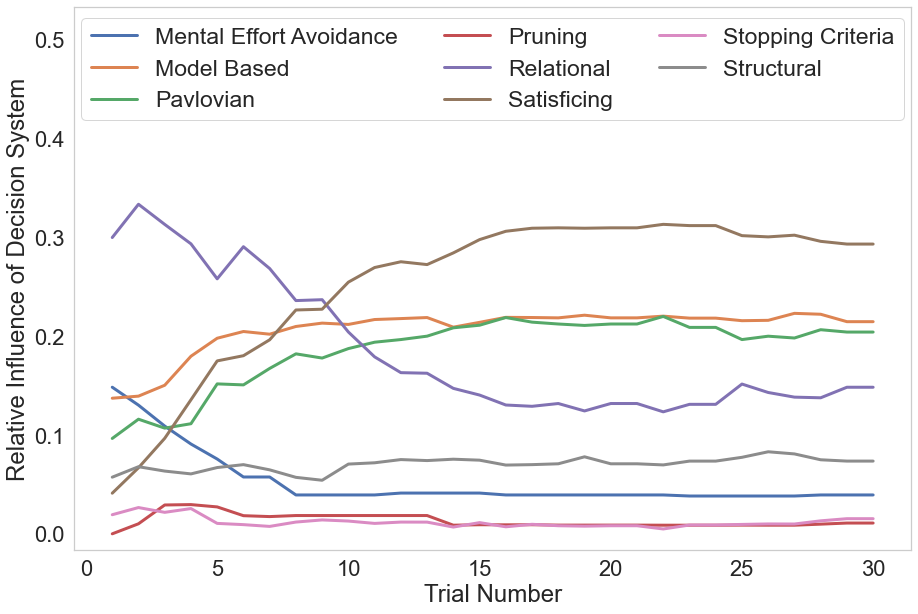

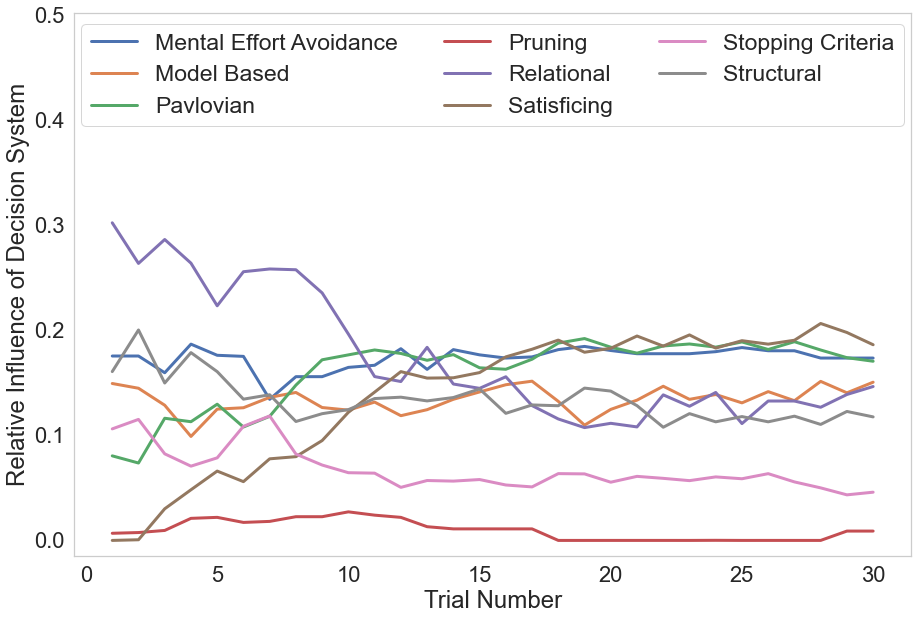

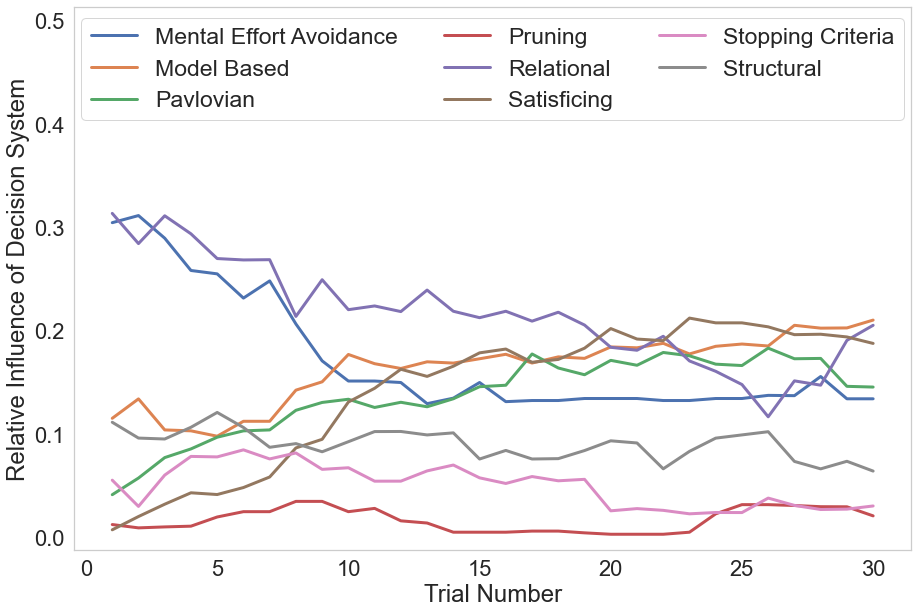

In [36]:
suffixes = ["meta", "action", "none"]
exp_s = [v1_meta_strategies, v1_action_strategies, v1_nofb_strategies]
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.infer_strategies(precomputed_strategies = exp_s[i], show_pids=False)
    exp.init_decision_system_properties(decision_systems, W_DS, DS_proportions)
    exp.plot_average_ds(suffix = suffixes[i])
    mean_dsw = exp.get_mean_DSW()
    
    print(exp.get_strategy_proportions()[21])
    print(exp.get_strategy_proportions()[30])

In [37]:
def sort_counts(counts):
    sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_counts

In [38]:
k = 4
strategies_set = set()
for exp, S in zip([v1_meta, v1_action, v1_nofb], [v1_meta_strategies, v1_action_strategies, v1_nofb_strategies]):
    exp.infer_strategies(precomputed_strategies=S, show_pids=False)
    counts = exp.get_strategy_proportions()
    sorted_counts = sort_counts(counts)
    strategies_set = strategies_set.union({p[0] for p in sorted_counts[:k]})
sorted(list(strategies_set))

[21, 30, 31, 42, 57, 58]

In [39]:
condition_optimal_planning = []
condition_no_planning = []
total_num = []
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    trial_props, total_counts = exp.get_strategy_frequencies(exp.participant_strategies, trial_wise=True)
    num_time_steps = max(trial_props.keys())+1
    optimal_props = np.zeros(num_time_steps)
    no_planning_props = np.zeros(num_time_steps)
    for t in trial_props.keys():
        if 21 in trial_props[t]:
            optimal_props[t] = trial_props[t][21]
        no_planning_props[t] = trial_props[t][30]
    condition_optimal_planning.append(optimal_props)
    condition_no_planning.append(no_planning_props)
    total_num.append(total_counts)
print(np.array(condition_optimal_planning), np.array(condition_no_planning))
print(total_num)

[[ 4.  7. 11. 17. 21. 22. 24. 28. 29. 32. 34. 35. 34. 35. 38. 39. 40. 40.
  40. 40. 40. 40. 40. 40. 38. 37. 38. 37. 37. 37.]
 [ 0.  0.  0.  2.  3.  4.  7.  8.  9. 11. 12. 14. 15. 13. 13. 17. 17. 19.
  16. 15. 17. 18. 18. 18. 19. 19. 18. 21. 19. 19.]
 [ 1.  2.  3.  4.  4.  5.  5.  9. 10. 16. 18. 20. 19. 19. 22. 22. 21. 21.
  22. 24. 23. 23. 24. 23. 23. 24. 24. 24. 23. 23.]] [[ 8.  7.  6.  5.  4.  3.  3.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 9.  9.  8.  9.  9.  9.  7.  8.  8.  8.  8.  9.  8.  9.  9.  9.  9.  9.
   9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]
 [16. 16. 15. 13. 13. 12. 13. 11.  9.  8.  8.  8.  7.  7.  8.  7.  7.  7.
   7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  7.  7.]]
[array([55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
       55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
       55., 55., 55., 55.]), array([54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
  

In [40]:
# Comparing time frequencies of two groups
from scipy.stats import chi2_contingency
# Comparing MCFB and No FB
g, p, dof, _ = chi2_contingency([condition_optimal_planning[0][-5:], condition_optimal_planning[2][-5:]])
print(np.round(g, 2), np.round(p,4), dof)
g, p, dof, _ = chi2_contingency([condition_no_planning[0], condition_no_planning[2]])
print(np.round(g, 2), np.round(p,4), dof)
g, p, dof, _ = chi2_contingency([condition_optimal_planning[1], condition_optimal_planning[2]])
print(np.round(g, 2), np.round(p,4), dof)
g, p, dof, _ = chi2_contingency([condition_no_planning[1], condition_no_planning[2]])
print(np.round(g, 2), np.round(p,4), dof)

0.03 0.9999 4
3.83 1.0 29
8.23 0.9999 29
14.14 0.9906 29


### Comparing the relative influence of decision trials in the first five trials versus the last five trials

(55, 30, 8)
0.006391150954545011
mental_effort_avoidance
t(108): -2.02, p: 0.0459
model_based
t(108): 2.63, p: 0.0098
pavlovian
t(108): 3.8, p: 0.0002
pruning
t(108): 1.06, p: 0.2894
relational
t(108): -2.99, p: 0.0034
satisficing
t(108): 9.87, p: 0.0
stopping_criteria
t(108): -0.87, p: 0.3847
structural
t(108): 0.9, p: 0.372


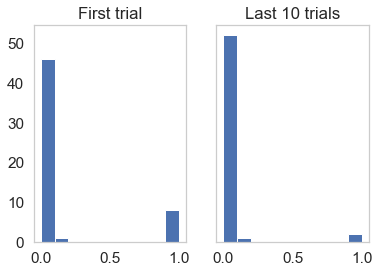

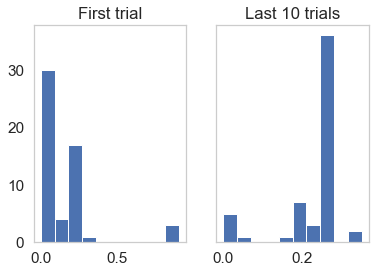

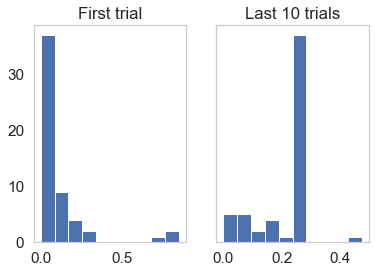

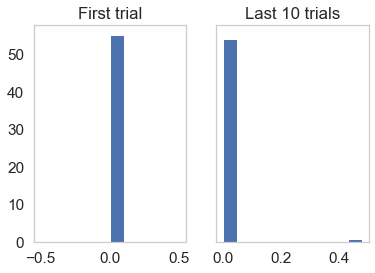

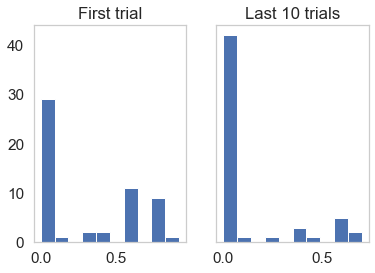

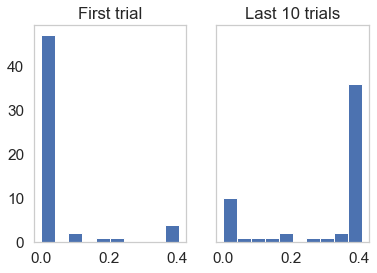

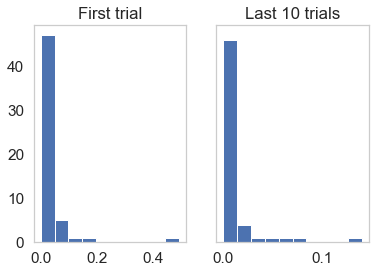

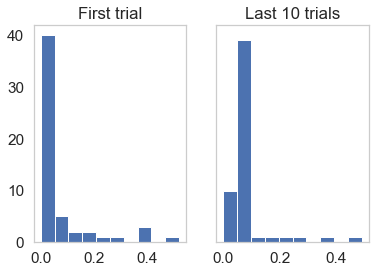

In [163]:
DSW = v1_meta.get_DSW()
DSW = np.array(DSW)
print(DSW.shape)
from learning_utils import sidak_value
alpha_sidak = sidak_value(0.05, 8)
print(alpha_sidak)
k = 5
for i in range(DSW.shape[-1]):
    print(decision_systems[i])
    x1 = np.mean(DSW[:, :1, i], axis=1)
    x2 = np.mean(DSW[:, -10:, i], axis=1)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    #f.suptitle(decision_systems[i])
    ax1.hist(x1)
    ax2.hist(x2)
    ax1.set_title("First trial")
    ax2.set_title("Last 10 trials")
    t_test(x2, x1)

[21, 30, 31, 42, 57, 58]


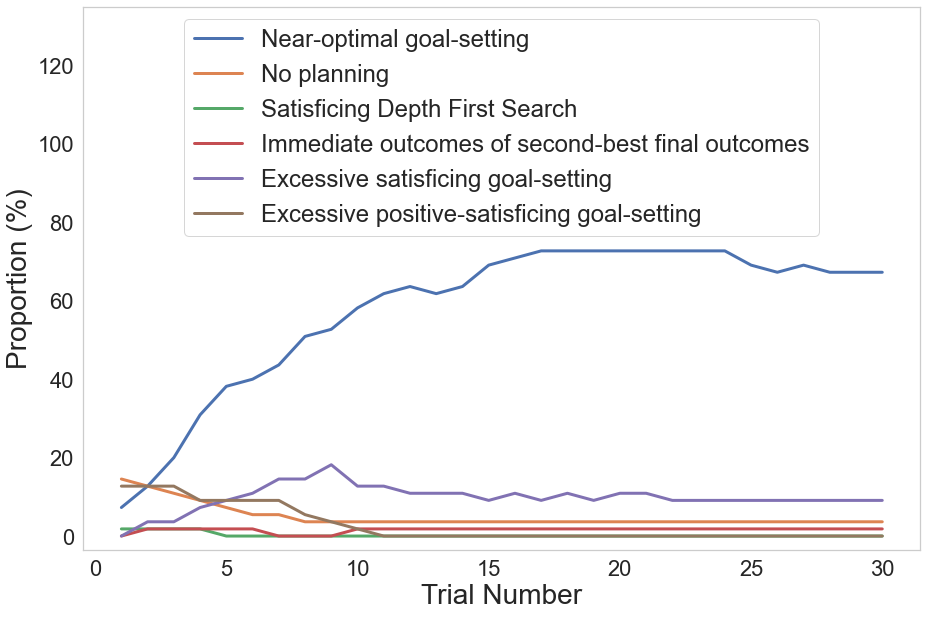

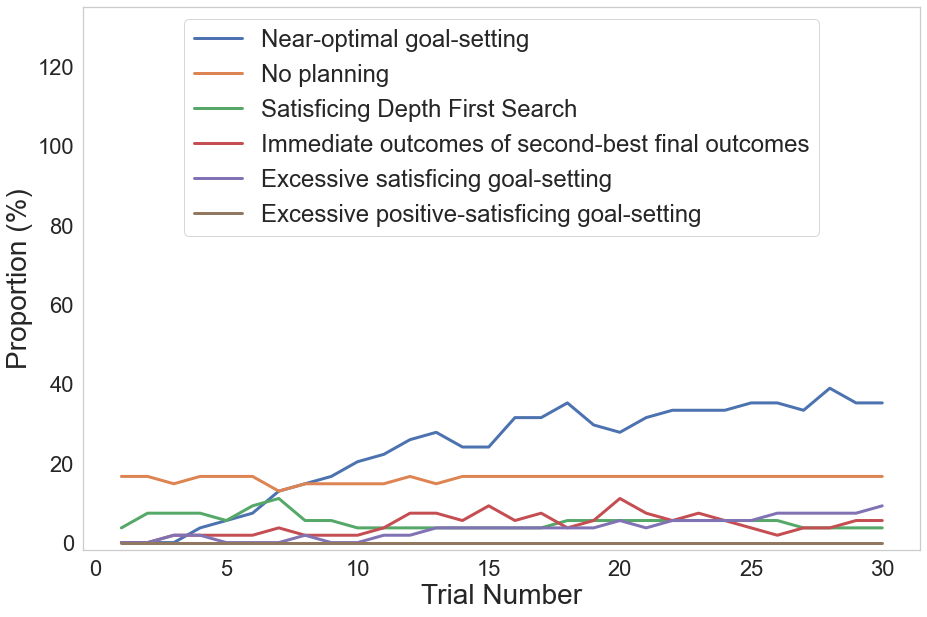

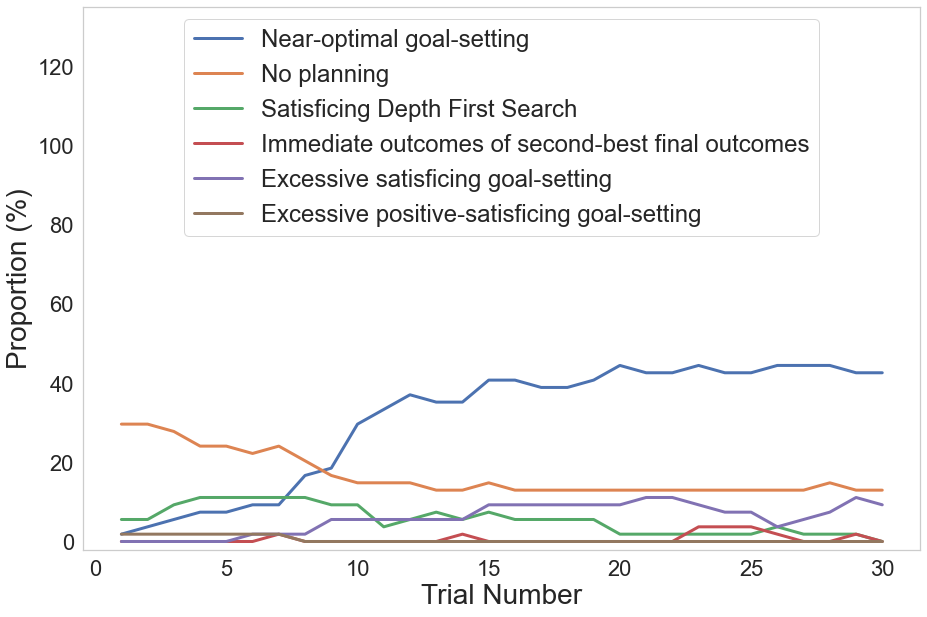

In [44]:
labels = ["Near-optimal goal-setting", "No planning", "Satisficing Depth First Search", "Immediate outcomes of second-best final outcomes", "Excessive satisficing goal-setting", "Excessive positive-satisficing goal-setting"]
conditions = ['meta', 'action', 'none']
print(sorted(list(strategies_set)))
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.plot_strategy_proportions(S = sorted(list(strategies_set)), labels=labels, suffix=conditions[i])

### Plotting experiment wise clusters

In [46]:
k = 3
best_c = set()
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.init_strategy_clusters(cluster_map)
    props = exp.get_cluster_proportions()
    sorted_props = sorted(props.items(), key=operator.itemgetter(1), reverse=True)
    for p in sorted_props[:k]:
        best_c.add(p[0])
best_c = sorted(list(best_c))
print(best_c)

[5, 7, 9, 10, 13]


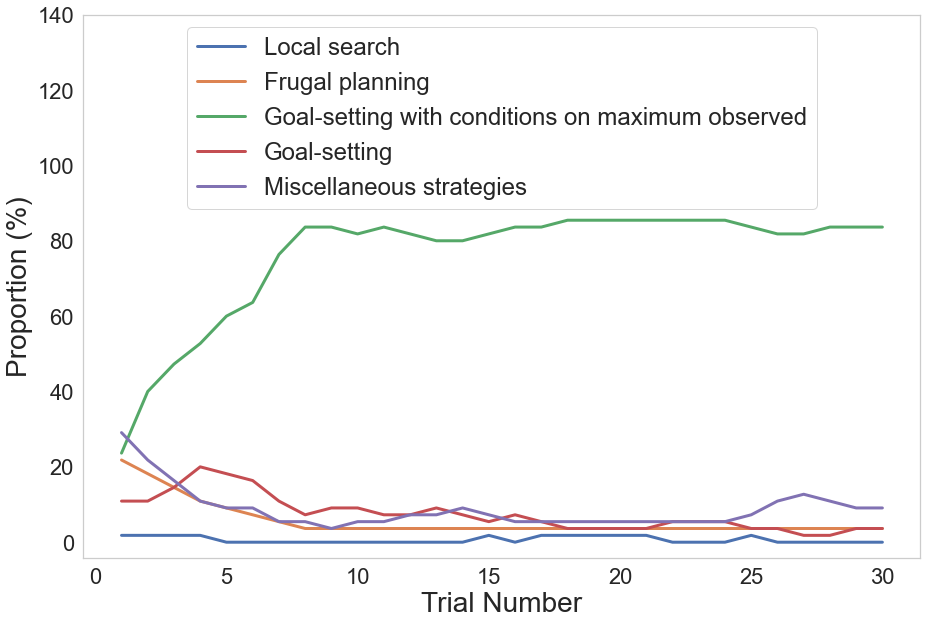

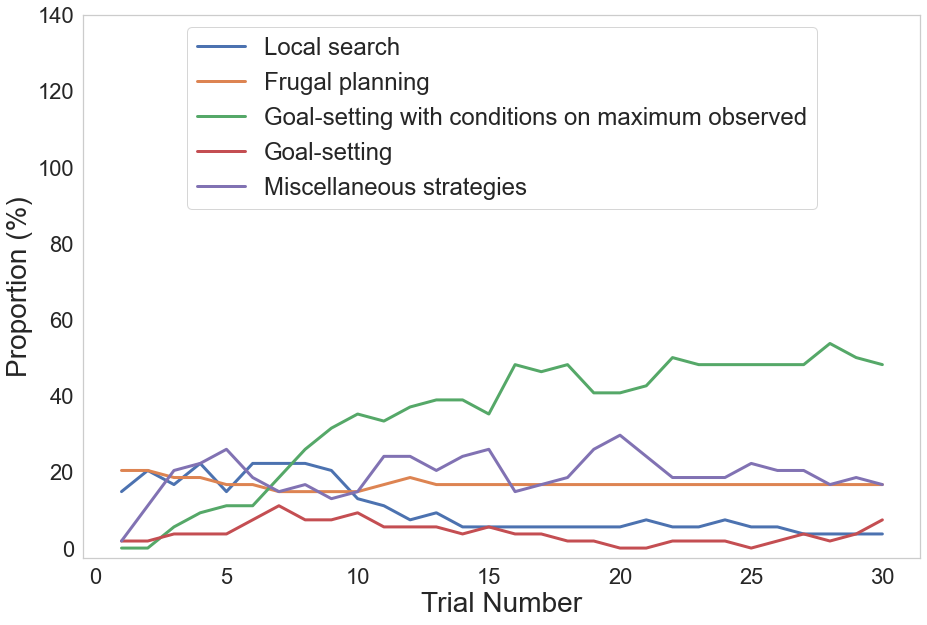

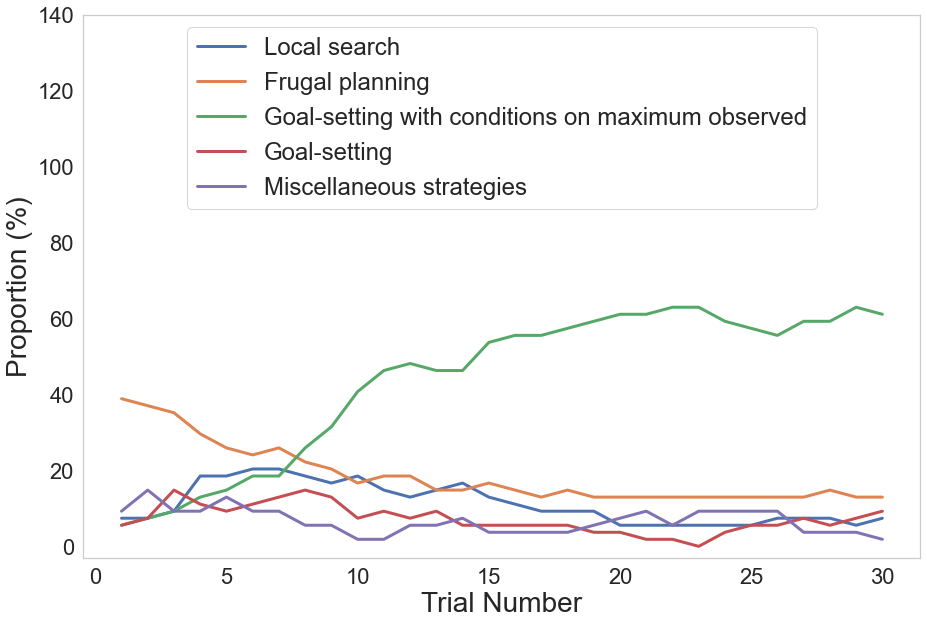

In [47]:
labels = ["Local search", "Frugal planning", "Goal-setting with conditions on maximum observed", "Goal-setting", "Miscellaneous strategies"]
conditions = ['meta', 'action', 'none']
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.plot_cluster_proportions(C = best_c, suffix = conditions[i], labels=labels, combine_other=False)

### Comparing statistics across conditions

0 0.01575757575757576
0 0.5781818181818181
0 0.0496969696969697
1 0.1518518518518519
1 0.23518518518518522
1 0.16172839506172842
2 0.13950617283950617
2 0.30925925925925923
2 0.16666666666666666


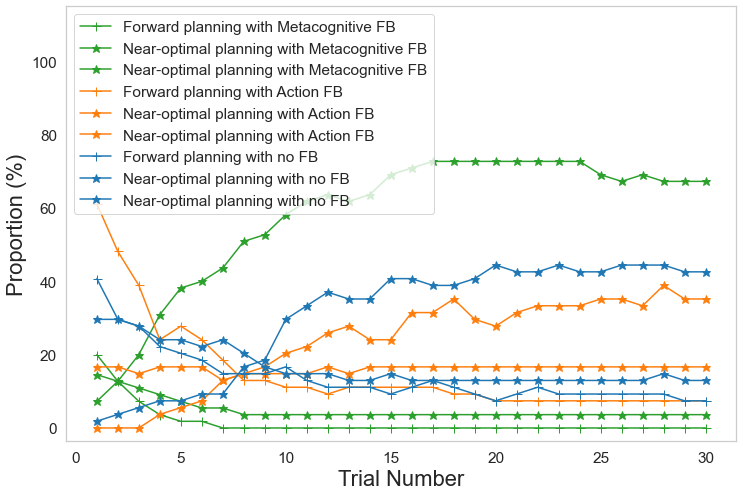

In [79]:
import matplotlib
forward_planning_strategies = [3, 10, 82, 5, 36, 37, 54, 79, 22, 23, 32, 33, 53, 64, 65, 69, 70, 80, 28, 34]
no_planning_strategies = [30]
goal_setting_strategies = [21]
conditions = ['Metacognitive FB', 'Action FB', 'No FB']
markers = ["*", "+", "o"]
forward_labels = ["Forward planning with Metacognitive FB", "Forward planning with Action FB", "Forward planning with no FB"]
goal_labels = ["Near-optimal planning with Metacognitive FB", "Near-optimal planning with Action FB", "Near-optimal planning with no FB"]
cmap = matplotlib.cm.get_cmap('tab10')
colors = [cmap(2), cmap(1), cmap(0)]
forward_freqs = {}
goal_setting_freqs = {}
no_planning_freqs = {}
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    s_props = exp.get_strategy_proportions(trial_wise=True)
    forward_freqs[conditions[i]] = np.sum([[s_props[t].get(s, 0) for t in sorted(s_props.keys())] for s in forward_planning_strategies], axis=0)
    goal_setting_freqs[conditions[i]] = np.sum([[s_props[t].get(s, 0) for t in sorted(s_props.keys())] for s in goal_setting_strategies], axis=0)
    no_planning_freqs[conditions[i]] = np.sum([[s_props[t].get(s, 0) for t in sorted(s_props.keys())] for s in no_planning_strategies], axis=0)
    print(i, np.mean(forward_freqs[conditions[i]]))
    print(i, np.mean(goal_setting_freqs[conditions[i]]))
    print(i, np.mean(no_planning_freqs[conditions[i]]))
plt.figure(figsize=(12, 8))
for c, condition in enumerate(conditions):
    plt.plot(range(1, 31), forward_freqs[condition]*100, marker = markers[1], color = colors[c], label=forward_labels[c], markersize=9)
    plt.plot(range(1, 31), goal_setting_freqs[condition]*100, marker = markers[0], color = colors[c], label=goal_labels[c], markersize=9)
    plt.plot(range(1, 31), no_planning_freqs[condition]*100, marker = markers[0], color = colors[c], label=goal_labels[c], markersize=9)
plt.legend()
plt.ylim(top=115)
plt.xlabel("Trial Number", fontsize=22)
plt.ylabel("Proportion (%)", fontsize=22)
plt.savefig("results/planning_conditions.pdf", bbox_inches='tight')

### Plotting frequencies of decision systems

['Experiment', 'Trial', 'Decision System', 'Relative Influence (%)']


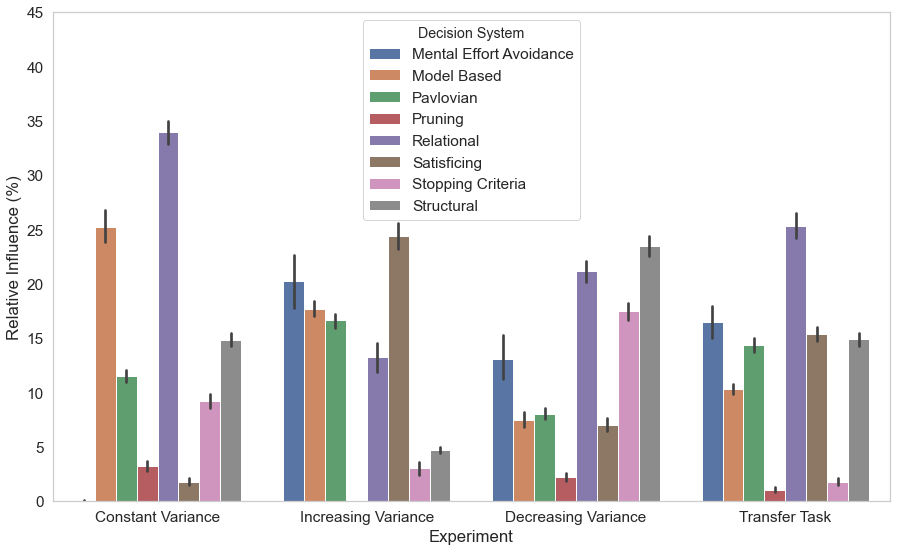

In [49]:
decision_system_labels = [" ".join([s.capitalize() for s in ds.split("_")]) for ds in decision_systems]
data_columns = ['Experiment', 'Trial', 'Decision System', 'Relative Influence (%)']
print(data_columns)
def get_ds_data(strategies, experiment_num):
    data = []
    for pid in strategies.keys():
        for i in range(len(strategies[pid])):
            for j in range(len(decision_system_labels)):
                data.append([experiment_num, i, decision_system_labels[j], DS_proportions[strategies[pid][i]-1][j]*100])
    return data
data = get_ds_data(c1_strategies, "Constant Variance")
data += get_ds_data(c2_inc_strategies, "Increasing Variance")
data += get_ds_data(c2_dec_strategies, "Decreasing Variance")
data += get_ds_data(T1_strategies, "Transfer Task")

df = pd.DataFrame(data, columns=data_columns)
plt.figure(figsize=(15, 9))
plt.ylim(top=45)
sns.barplot(x = "Experiment", y = "Relative Influence (%)", hue="Decision System", data=df)
plt.savefig("results/structure_influence_ds.pdf", bbox_inches='tight')

### Plotting frequencies of strategies

{65, 37, 70, 21, 22, 57, 30, 63}
[21, 22, 30, 37, 57, 63, 65, 70]


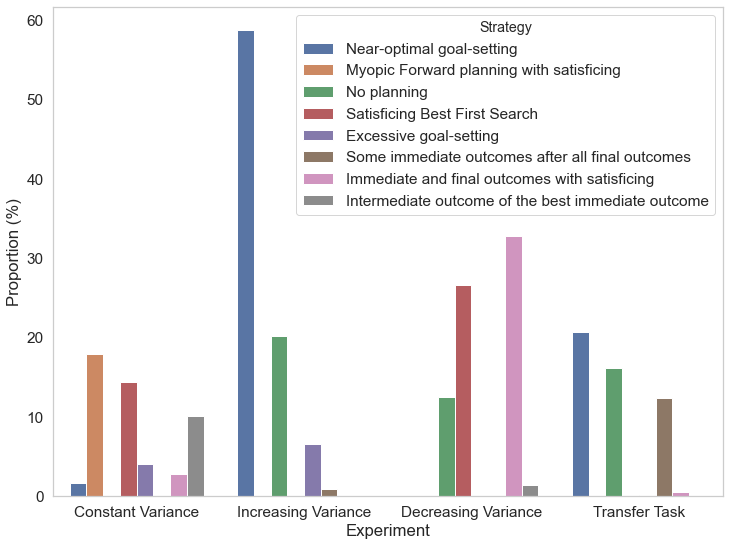

In [50]:
def get_strategy_proportions(strategies):
    S = []
    for s in strategies.values():
        if type(s) == list:
            S += s
    counts = Counter(S)
    total_counts = sum(counts.values())
    counts = {k: v/total_counts for k, v in counts.items()}
    return defaultdict(int, counts)

def get_top_k(counts, k=4):
    S = {c[0] for c in counts[:k]}
    return S
    
c1_counts = get_strategy_proportions(c1_strategies)
c2_inc_counts = get_strategy_proportions(c2_inc_strategies)
c2_dec_counts = get_strategy_proportions(c2_dec_strategies)
transfer_counts = get_strategy_proportions(T1_strategies)

reward_structure_counts = [c1_counts, c2_inc_counts, c2_dec_counts, transfer_counts]
strategies_set = set()
for counts in reward_structure_counts:
    strategies_set = strategies_set.union(get_top_k(sort_counts(counts), k=3))

print(strategies_set)
strategies_list = sorted(list(strategies_set))
print(strategies_list)

reward_structures = ['Constant Variance', 'Increasing Variance', 'Decreasing Variance', 'Transfer Task']
data = []
columns = ['Experiment', 'Strategy', 'Proportion (%)']
strategy_labels = ["Near-optimal goal-setting", "Myopic Forward planning with satisficing", "No planning", "Satisficing Best First Search", "Excessive goal-setting",
                  "Some immediate outcomes after all final outcomes", "Immediate and final outcomes with satisficing", "Intermediate outcome of the best immediate outcome"]
for i in range(len(reward_structures)):
    for strategy in strategies_list:
        data.append([reward_structures[i], strategy_labels[strategies_list.index(strategy)], reward_structure_counts[i][strategy]*100])
        #data.append([reward_structures[i], strategy, reward_structure_counts[i][strategy]*100])
df = pd.DataFrame(data, columns=columns)
plt.figure(figsize=(12, 9))
sns.barplot(x = 'Experiment', y='Proportion (%)', hue='Strategy', data=df)
plt.savefig("results/structure_influence_sprop.pdf", bbox_inches='tight')

### Plotting clusters of v1 and transfer task

Strategies for 103 not found. Skipping adding strategy data
[(9, 0.5171779141104295), (7, 0.13680981595092023), (13, 0.11533742331288344), (5, 0.07321063394683026), (10, 0.06237218813905931), (8, 0.05991820040899796), (4, 0.029243353783231084), (2, 0.0028629856850715747), (12, 0.0014314928425357874), (11, 0.0010224948875255625), (3, 0.0006134969325153375)] [(9, 0.38916666666666666), (13, 0.24625), (7, 0.16166666666666665), (10, 0.0675), (12, 0.044583333333333336), (5, 0.04125), (8, 0.0325), (1, 0.009583333333333333), (4, 0.0075)]
{5, 7, 9, 10, 12, 13}
[5, 7, 9, 10, 12, 13]


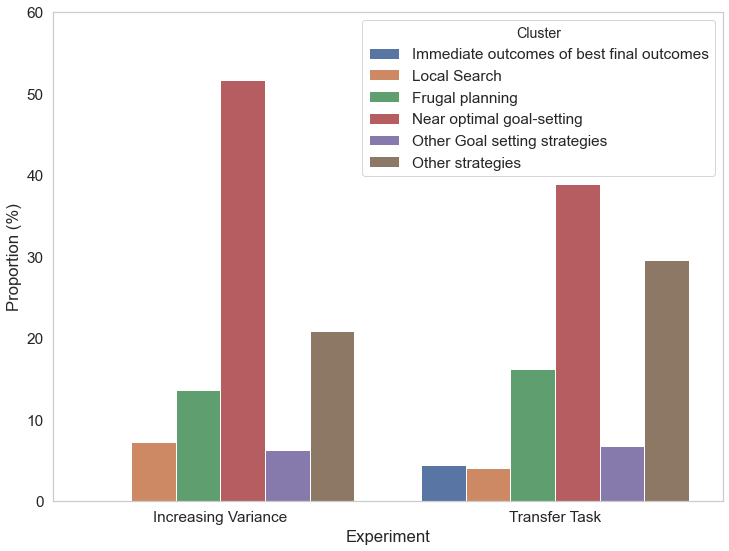

In [51]:
v1.infer_strategies(v1_strategies, show_pids=False)
T1.infer_strategies(T1_strategies, show_pids=False)
v1.init_strategy_clusters(cluster_map)
T1.init_strategy_clusters(cluster_map)
#v1.plot_cluster_proportions(C=list(range(1, 14)))
#T1.plot_cluster_proportions(C=list(range(1, 14)))
v1_proportions = get_strategy_proportions(v1.participant_clusters)
T1_proportions = get_strategy_proportions(T1.participant_clusters)
v1_cluster_counts = sort_counts(v1_proportions)
T1_cluster_counts = sort_counts(T1_proportions)
print(v1_cluster_counts, T1_cluster_counts)

k = 5
clusters_set = set()
for counts in [v1_cluster_counts, T1_cluster_counts]:
    for p in counts[:k]:
        clusters_set.add(p[0])
print(clusters_set)

cluster_list = sorted(list(clusters_set))
print(cluster_list)
cluster_list = [12, 5, 7, 9, 10, 13]
reward_structures = ['Increasing Variance', 'Transfer Task']
reward_structure_counts = [v1_proportions, T1_proportions]
data = []
columns = ['Experiment', 'Cluster', 'Proportion (%)']
cluster_labels = ["Immediate outcomes of best final outcomes", "Local Search", "Frugal planning", "Near optimal goal-setting", "Other Goal setting strategies", "Other strategies"]
for i in range(len(reward_structures)):
    t_prop = 0
    for j, cluster in enumerate(cluster_list[:-1]):
        data.append([reward_structures[i], cluster_labels[j], reward_structure_counts[i][cluster]*100])
        t_prop += reward_structure_counts[i][cluster]
    data.append([reward_structures[i], cluster_labels[-1], (1- t_prop)*100])
df = pd.DataFrame(data, columns=columns)
plt.figure(figsize=(12, 9))
sns.barplot(x = 'Experiment', y='Proportion (%)', hue='Cluster', data=df)
plt.ylim(top = 60)
plt.savefig("results/cluster_transfer.pdf", bbox_inches='tight')

F1 Num strategies: 26
v1.0 Num strategies: 25
c1.1 Num strategies: 16
c2.1_inc Num strategies: 4
c2.1_dec Num strategies: 5
T1.1 Num strategies: 17
43


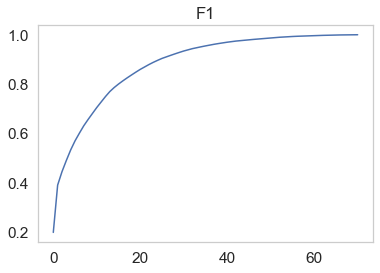

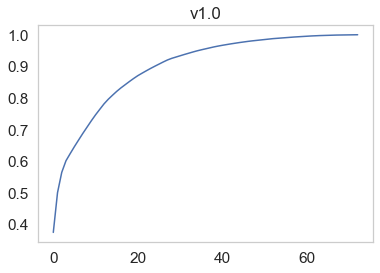

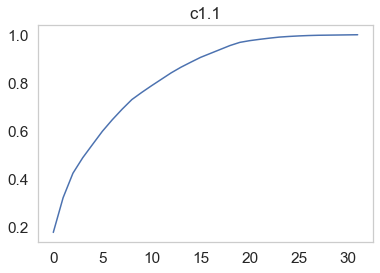

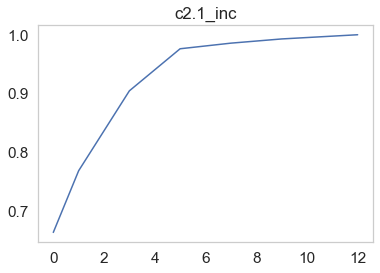

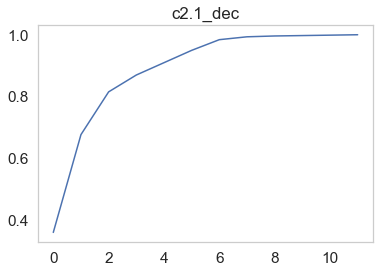

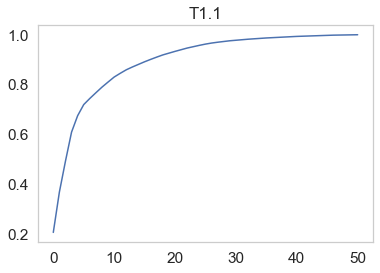

In [52]:
threshold = 0.90
exp_nums = ["F1", "v1.0", "c1.1", "c2.1_inc", "c2.1_dec", "T1.1"]
exps = [F1, v1, c1, c2_inc, c2_dec, T1]
strategies_set = set()
strategies = [F1_strategies, v1_strategies, c1_strategies, c2_inc_strategies, c2_dec_strategies, T1_strategies]
for exp_num, exp, S in zip(exp_nums, exps, strategies):
    exp.infer_strategies(precomputed_strategies=S, show_pids=False)
    strategy_proportions = exp.get_strategy_proportions()
    props = sorted(strategy_proportions.items(), key=operator.itemgetter(1), reverse=True)
    top_k_props = [p[1] for p in props]
    k_cumsum = np.cumsum(top_k_props)
    cutoff = 0
    for i, c in enumerate(k_cumsum):
        if c > threshold:
            cutoff = i
            break
    for p in props[:i+1]:
        strategies_set.add(p[0])
    print(exp_num, "Num strategies:", i+1)
    plt.figure()
    plt.title(exp_num)
    plt.plot(k_cumsum)
print(len(strategies_set))

Strategy transitions
('action', 'none')
Number of significant transitions: 11
Number of insignificant transitions: 372
Alpha sidak: 0.0001339160830610142
Significant transitions: [((53, 53), (0.0006, 0.0115), 15.3, 0.0001), ((17, 17), (0.0153, 0.0), 24.19, 0.0), ((18, 18), (0.0307, 0.007), 23.65, 0.0), ((42, 42), (0.0338, 0.0032), 40.47, 0.0), ((23, 23), (0.0358, 0.0045), 38.89, 0.0), ((21, 21), (0.2241, 0.2969), 21.54, 0.0), ((67, 67), (0.0128, 0.0), 20.13, 0.0), ((37, 37), (0.0313, 0.0), 49.78, 0.0), ((56, 56), (0.0, 0.0185), 29.27, 0.0), ((65, 65), (0.0, 0.0192), 30.29, 0.0), ((40, 40), (0.0019, 0.0172), 19.39, 0.0)]


('action', 'meta')
Number of significant transitions: 14
Number of insignificant transitions: 318
Alpha sidak: 0.00015448594047928754
Significant transitions: [((57, 57), (0.0307, 0.0909), 50.05, 0.0), ((18, 18), (0.0307, 0.0025), 38.68, 0.0), ((58, 58), (0.0, 0.0238), 37.76, 0.0), ((79, 79), (0.0102, 0.0), 16.38, 0.0001), ((22, 22), (0.0255, 0.0006), 38.32, 0.0), ((2

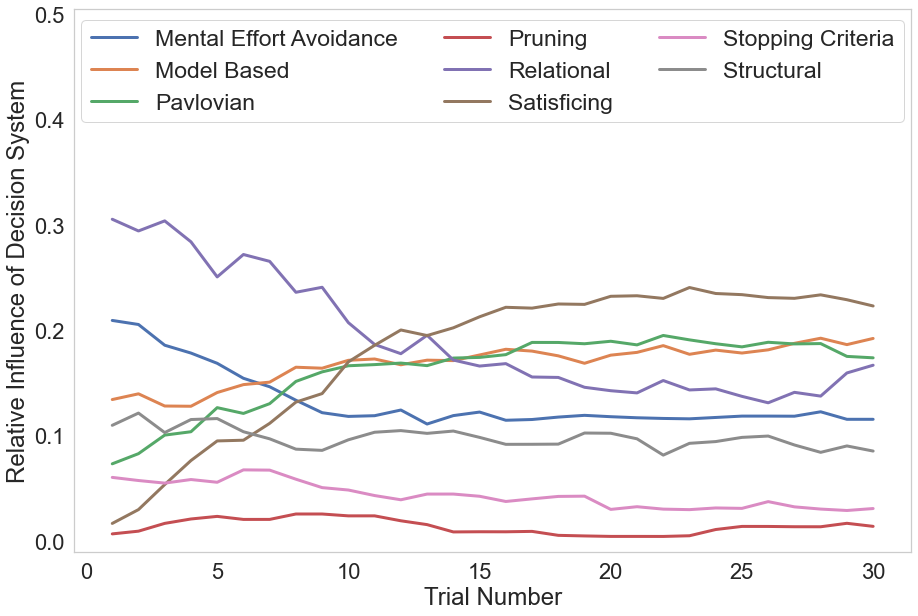

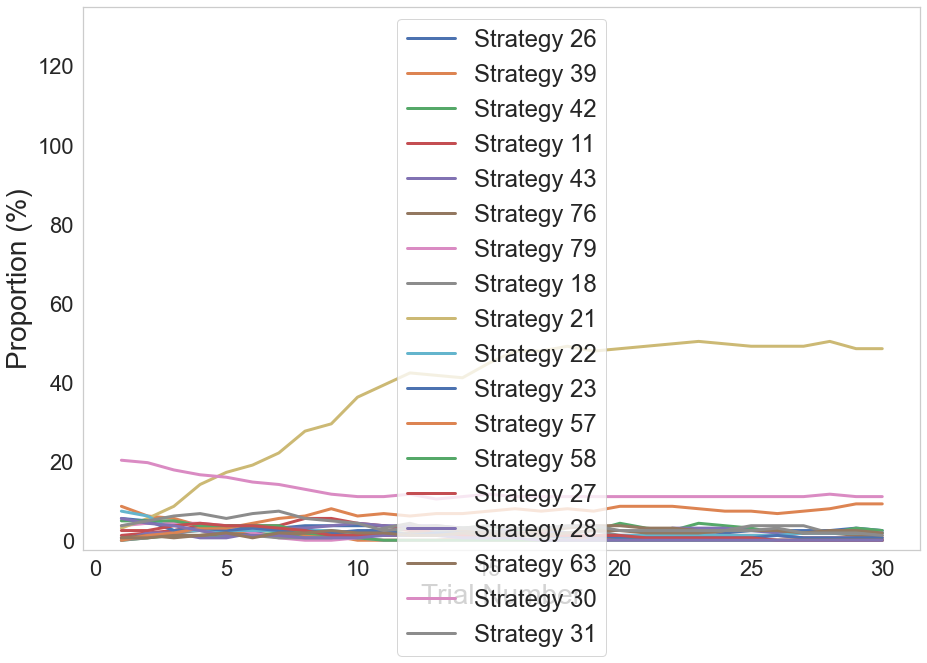

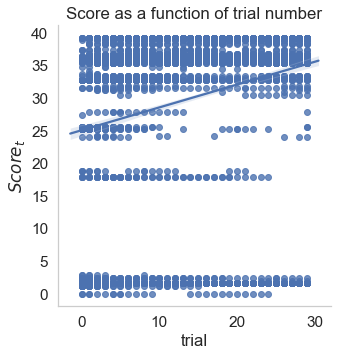

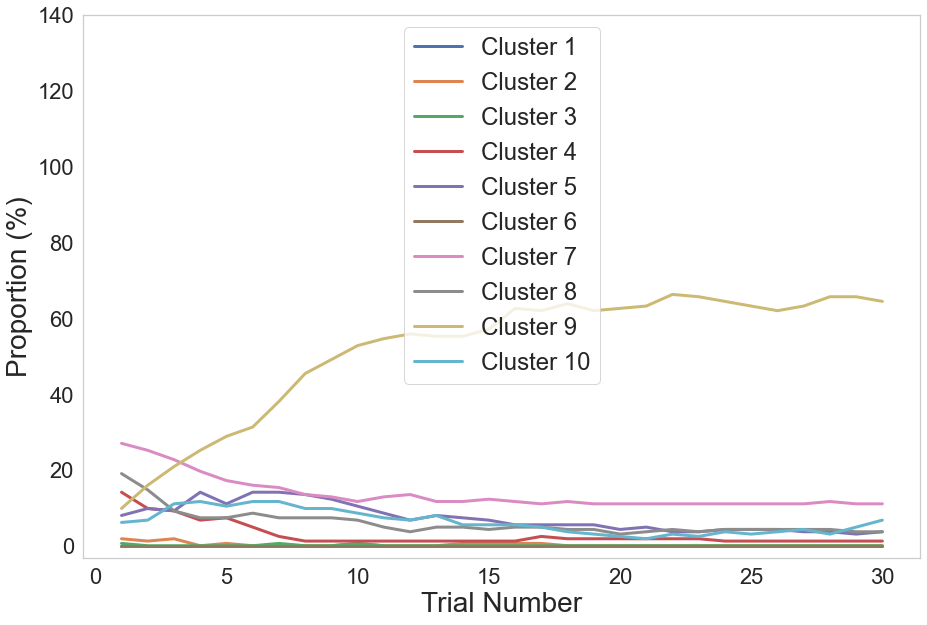

In [53]:
v1.summarize(features, normalized_features, strategy_weights, decision_systems, W_DS, DS_proportions, strategy_scores, cluster_scores, cluster_map, precomputed_strategies=v1_strategies, show_pids=False)

In [54]:
# E.plot_strategy_proportions(S = [21, 30])
uniform_strategies = pickle_load("results/uniform_prior_inferences/v1.0_strategies.pkl")
v1.infer_strategies(precomputed_strategies=uniform_strategies, show_pids = False)
transition_frequencies = v1.get_transition_frequencies()

### Chi2 test for showing that a random self transition is more probable than a random transition

Make sure to say that it is from the set of observed transitions and not from the set of all transitions

In [55]:
self_transition_counts = []
transition_counts = []
for tr, k in transition_frequencies.items():
    if tr[0] != tr[1]:
        transition_counts.append(k)
    else:
        self_transition_counts.append(k)
print(self_transition_counts, transition_counts)

[28, 24, 75, 3, 410, 8, 3, 3, 3, 538, 12, 32, 25, 48, 3, 17, 4, 19, 9, 12, 14, 43, 1, 6, 2, 34, 6, 28, 13, 6, 4, 4, 7, 3, 1, 4, 3, 8, 7, 2, 3, 1, 1, 3, 2, 4, 4, 1, 1, 1, 2, 1, 1, 3, 1, 1] [1, 6, 4, 2, 2, 5, 5, 6, 44, 3, 1, 5, 7, 5, 4, 80, 89, 46, 75, 88, 1, 1, 4, 1, 4, 2, 1, 3, 3, 1, 1, 3, 1, 2, 2, 2, 2, 55, 6, 7, 4, 11, 11, 12, 1, 1, 11, 15, 1, 1, 9, 5, 4, 13, 10, 2, 1, 7, 2, 31, 23, 2, 2, 9, 3, 1, 2, 7, 4, 3, 4, 7, 44, 5, 2, 13, 38, 1, 1, 9, 1, 1, 20, 11, 4, 67, 13, 11, 5, 9, 3, 1, 9, 4, 34, 6, 37, 4, 1, 1, 9, 4, 2, 6, 5, 6, 3, 1, 2, 4, 2, 4, 4, 1, 3, 7, 4, 5, 9, 2, 1, 3, 2, 3, 3, 11, 18, 1, 6, 12, 2, 6, 9, 1, 5, 1, 2, 2, 16, 5, 15, 6, 4, 5, 55, 1, 1, 4, 18, 4, 4, 1, 3, 12, 10, 12, 2, 2, 2, 13, 2, 1, 1, 22, 22, 9, 1, 1, 2, 4, 3, 1, 9, 12, 1, 4, 2, 2, 2, 3, 1, 2, 33, 3, 1, 1, 1, 1, 3, 4, 2, 2, 4, 1, 1, 5, 1, 1, 1, 1, 4, 2, 1, 1, 6, 5, 5, 5, 1, 5, 2, 6, 2, 2, 13, 2, 4, 1, 1, 3, 2, 1, 2, 2, 1, 3, 1, 2, 1, 1, 1, 5, 5, 3, 7, 8, 3, 2, 5, 5, 1, 7, 2, 1, 3, 2, 4, 27, 3, 3, 7, 7, 1, 2, 1, 1, 

In [56]:
t, p = ttest_ind(self_transition_counts, transition_counts)
print(np.round(t, 2), np.round(p, 4))
print(len(self_transition_counts) + len(transition_counts)-2)

7.55 0.0
975
